ASSIGNMENT 2 - Daniele Gotti

INTRODUCTION

This notebook contains the code for the waste-type classifier, the analysis with the plots, and the final model, which was upload on HuggingFace.

For the code, I followed as closely as possible the exercises presented during class, particularly *Lesson5_Part1.ipynb* and the given instructions in *Assignment2.ipynb*, but I reorganized it in a more engineering-oriented manner, encapsulating operations into functions to allow for easy modification of the parameters during the analysis and optimal model selection.

PART 1 - IMPLEMENTING AND TRAINING CNN AND TRANSFORMER

In [ ]:
# import all the libraries
import sys
import copy
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.data import random_split
from torchvision import transforms, datasets
from torchvision import models
from google.colab import drive

In [ ]:
# mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# some constants
IMG_SIZE = 224
NUM_CLASSES=9
SUBSET_SIZE=100
BATCH_SIZE = 16
NUM_PATCHES=7*7
EMBED_DIM=256
NUM_HEADS=8
NUM_LAYERS=2

In [ ]:
# define the transforms
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# root folder of your dataset
train_path = '/content/drive/MyDrive/train/'

trainset = datasets.ImageFolder(root=train_path, transform=transform)
# to load a subset of train set for debugging
subset_size = len(trainset) if SUBSET_SIZE==-1 else min(SUBSET_SIZE, len(trainset))
# randomly choose indices
indices = torch.randperm(len(trainset))[:subset_size]
train_subset = Subset(trainset, indices)
trainloader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=False)

In [ ]:
# check if the drive is mounted
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
trainset.classes

['Cardboard',
 'Food Organics',
 'Glass',
 'Metal',
 'Miscellaneous Trash',
 'Paper',
 'Plastic',
 'Textile Trash',
 'Vegetation']

Plastic,Miscellaneous Trash,Plastic,Metal,Glass


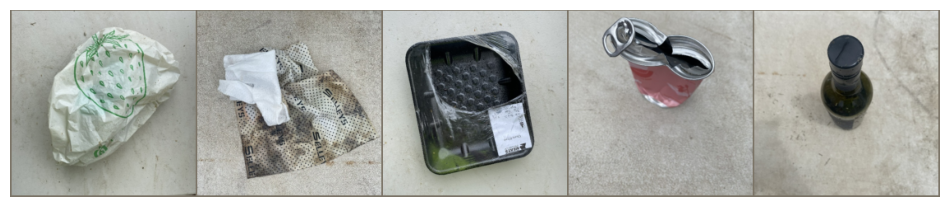

In [ ]:
def showimage(images):
  # unnormalize the images
  images = images * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
  npimgs = images.numpy()
  plt.figure(figsize=(12, 12))
  plt.imshow(np.transpose(npimgs, (1, 2, 0)))
  plt.axis('off')

# get random images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
img_grid = torchvision.utils.make_grid(images[5:10])
showimage(img_grid)

# print labels
print(','.join(f"{trainset.classes[idx]}" for idx in labels[5:10]))

In [ ]:
# Resnet transformer classifier
class ResnetTransformer(nn.Module):
    def __init__(self, embed_dim, num_patches, num_heads, num_layers, num_classes=9):
        super().__init__()

        # get a pre-trained ResNet-18 backbone
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2]) # remove the last two layers
        resnet_feat_dim = 512 # number of features

        # add a projection layer between resnet and transformer
        self.proj_layer = nn.Linear(resnet_feat_dim, embed_dim)

        # positional embedding
        self.pos_embedding = nn.Parameter(
            torch.randn(1, 1 + num_patches, embed_dim),
            requires_grad=True
        )

        # CLS token
        self.class_token = nn.Parameter(
            torch.randn(1, 1, embed_dim),
            requires_grad=True
        )

        # transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim*4,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        # classification head
        self.class_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )


    def forward(self, x):
        bs = x.shape[0]

        # extract features from Resnet
        feat = self.backbone(x) # shape (bs, 512, 7, 7)

        feat = feat.flatten(2) # flatten to tokens of shape (bs, 512, 49)

        feat = feat.transpose(1, 2) # (bs, 512, 49) -> (bs, 49, 512)

        # apply the projection layer
        feat = self.proj_layer(feat) # (bs, 49, 512) -> (bs, 49, embed_dim)

        # forward pass
        class_token = self.class_token.expand(bs, -1, -1)
        x = torch.cat((class_token, feat), dim=1)
        x = x + self.pos_embedding
        x = self.transformer(x)
        cls_out = x[:, 0, :]
        out = self.class_head(cls_out)

        return out

In [ ]:
# initialize the model
model = ResnetTransformer(
    embed_dim=EMBED_DIM,
    num_patches=NUM_PATCHES,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    num_classes=NUM_CLASSES
)

print(model)

# freeze the parameters of the backbone layers to save memory
for p in model.backbone.parameters():
    p.requires_grad = False

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {num_params}')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 200MB/s]

ResnetTransformer(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [ ]:
# helper function to prepare data
def prepare_dataloaders(dataset, batch_size, val_split=0.2, subset_ratio=1.0):

    total_len = len(dataset)

    # if a subset is requested (e.g., 0.1 for 10%)
    if subset_ratio < 1.0:
        reduced_len = int(total_len * subset_ratio)
        # random indices to select a sparse sample
        indices = torch.randperm(total_len)[:reduced_len]
        # overwrite the dataset with the reduced version
        dataset = Subset(dataset, indices)
        print(f"REDUCED DATASET ACTIVE: Using {reduced_len} images out of {total_len}")
    else:
        print(f"FULL DATASET: Using all {total_len} images")

    # split into train and validation
    train_size = int((1 - val_split) * len(dataset))
    val_size = len(dataset) - train_size
    train_subset, val_subset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_loader, val_loader

In [ ]:
# helper function to plot results
def plot_results(train_acc_ar, val_acc_ar, train_loss_ar, val_loss_ar):
    epochs = np.arange(len(val_acc_ar)) + 1

    fig, (plot1, plot2) = plt.subplots(1, 2, figsize=(15, 5))

    # visualize the train and validation accuracy in a plot
    train_acc = np.array(train_acc_ar) * 100.
    val_acc = np.array(val_acc_ar) * 100.
    plot1.plot(epochs, train_acc, label='train acc', color='red')
    plot1.plot(epochs, val_acc, label='val acc', color='green')
    plot1.set_title('Accuracy plot')
    plot1.set_xlabel('epochs')
    plot1.set_ylabel('accuracy (%)')
    plot1.set_xticks(epochs)
    plot1.legend()

    # visualize the train and validation loss in a plot
    train_loss = np.array(train_loss_ar)
    val_loss = np.array(val_loss_ar)
    plot2.plot(epochs, train_loss, label='train loss', color='red')
    plot2.plot(epochs, val_loss, label='val loss', color='green')
    plot2.set_title('Loss plot')
    plot2.set_xlabel('epochs')
    plot2.set_ylabel('loss')
    plot2.set_xticks(epochs)
    plot2.legend()

    plt.show()

In [ ]:
# helper function to train the model
def train_model(model, train_dataloader, val_dataloader, num_epochs, lr, unfreeze_backbone=False):
    # check if GPU or not
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # move the model to the gpu
    model = model.to(device)

    # handle unfreezing
    if unfreeze_backbone:
        print("Unfreezing ResNet backbone")
        for param in model.backbone.parameters():
            param.requires_grad = True
    else:
        for param in model.backbone.parameters():
            param.requires_grad = False

    # loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    # lists for plotting
    train_loss_ar = []
    train_acc_ar = []
    val_loss_ar = []
    val_acc_ar = []

    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    # beginning of training loop
    for epoch in range(num_epochs):
      model.train() # put the model in train mode
      train_loss = 0.0
      correct = 0
      total = 0

      total_batches = len(train_dataloader)

      print(f"Epoch [{epoch + 1}/{num_epochs}] ", end="")

      # training loop
      for i, (images, labels) in enumerate(train_dataloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # progress bar
        percent = (i + 1) / total_batches * 100
        print(f"\rEpoch [{epoch + 1}/{num_epochs}] Training: {percent:.0f}%", end="", flush=True)

      scheduler.step()

      train_loss = train_loss / total
      train_acc = correct / total
      train_loss_ar.append(train_loss)
      train_acc_ar.append(train_acc)

      # validation loop
      print(f"\rEpoch [{epoch + 1}/{num_epochs}] Validating ", end="", flush=True)

      model.eval()
      val_loss = 0.0
      val_correct = 0
      val_total = 0

      with torch.no_grad():
        for images, labels in val_dataloader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          loss = criterion(outputs, labels)

          val_loss += loss.item() * images.size(0)
          val_total += labels.size(0)
          _, predicted = torch.max(outputs, 1)
          val_correct += (predicted == labels).sum().item()

      val_loss = val_loss / val_total
      val_acc = val_correct / val_total
      val_loss_ar.append(val_loss)
      val_acc_ar.append(val_acc)

      # final results
      print(f"\rEpoch [{epoch + 1}/{num_epochs}] "
            f"Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.4f} | "
            f"Val loss: {val_loss:.4f} | Val accuracy: {val_acc:.4f}")

      if val_acc > best_val_acc:
          best_val_acc = val_acc
          best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model, train_loss_ar, train_acc_ar, val_loss_ar, val_acc_ar

PART 2 - FINDING THE BEST CONFIGURATION

EXPERIMENT 0

Establishes a baseline with a small architecture (128 dim, 1 layer) and a frozen ResNet backbone.

FULL DATASET: Using all 3323 images

EXPERIMENT 0
Using device: cuda
Epoch [1/10] Train loss: 2.1139 | Train accuracy: 0.2005 | Val loss: 2.0664 | Val accuracy: 0.2286
Epoch [2/10] Train loss: 1.9378 | Train accuracy: 0.2893 | Val loss: 1.8053 | Val accuracy: 0.4150
Epoch [3/10] Train loss: 1.6383 | Train accuracy: 0.4725 | Val loss: 1.4656 | Val accuracy: 0.5549
Epoch [4/10] Train loss: 1.3466 | Train accuracy: 0.5576 | Val loss: 1.2307 | Val accuracy: 0.5925
Epoch [5/10] Train loss: 1.1638 | Train accuracy: 0.5986 | Val loss: 1.0957 | Val accuracy: 0.6286
Epoch [6/10] Train loss: 1.0501 | Train accuracy: 0.6400 | Val loss: 1.0121 | Val accuracy: 0.6632
Epoch [7/10] Train loss: 0.9724 | Train accuracy: 0.6591 | Val loss: 0.9689 | Val accuracy: 0.6767
Epoch [8/10] Train loss: 0.9161 | Train accuracy: 0.6900 | Val loss: 0.9224 | Val accuracy: 0.6902
Epoch [9/10] Train loss: 0.8511 | Train accuracy: 0.7205 | Val loss: 0.8926 | Val accuracy: 0.6917
Epoch [10/10] Train loss: 0.8112 | Train

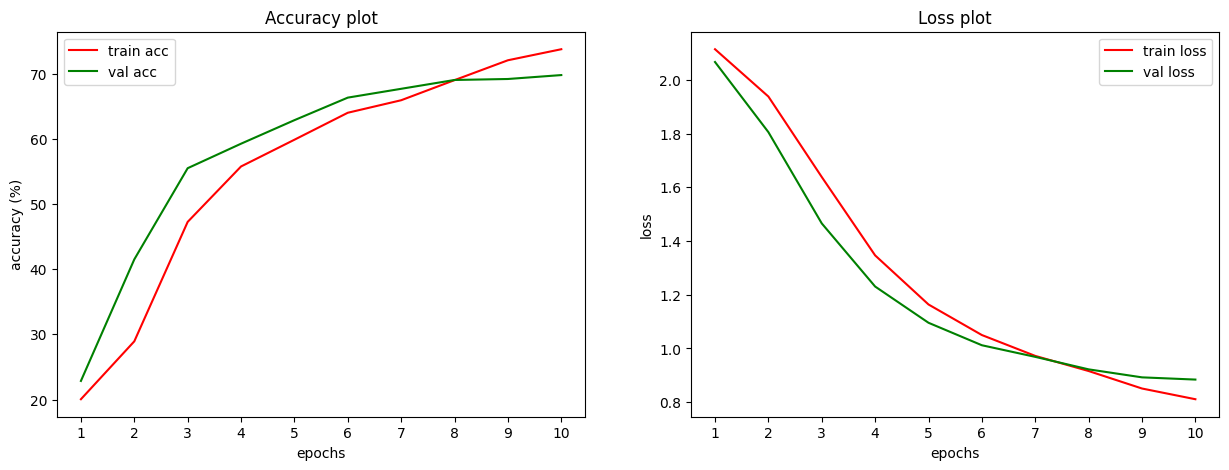

In [ ]:
FAST_RATIO = 1
BATCH_SIZE = 128
EPOCHS = 10

train_dl_std, val_dl_std = prepare_dataloaders(trainset, batch_size=BATCH_SIZE, subset_ratio=FAST_RATIO)

print("\nEXPERIMENT 0")
m0 = ResnetTransformer(embed_dim=128, num_patches=49, num_heads=4, num_layers=1, num_classes=9)
_, t_l0, t_a0, v_l0, v_a0 = train_model(m0, train_dl_std, val_dl_std, EPOCHS, lr=1e-4, unfreeze_backbone=False)

plot_results(t_a0, v_a0, t_l0, v_l0)

The baseline model shows decent initial learning but suffers from slight overfitting, with validation accuracy plateauing around 70%.

EXPERIMENT 1

Increases model capacity by doubling the embedding dimension to 256 and the number of layers to 2. It tests if the dataset is complex enough to benefit from a much larger parameter space.


EXPERIMENT 1
Using device: cuda
Epoch [1/10] Train loss: 1.9533 | Train accuracy: 0.2931 | Val loss: 1.6619 | Val accuracy: 0.4812
Epoch [2/10] Train loss: 1.3842 | Train accuracy: 0.5406 | Val loss: 1.1780 | Val accuracy: 0.5820
Epoch [3/10] Train loss: 1.0262 | Train accuracy: 0.6415 | Val loss: 0.9589 | Val accuracy: 0.6722
Epoch [4/10] Train loss: 0.8571 | Train accuracy: 0.7028 | Val loss: 0.8866 | Val accuracy: 0.6932
Epoch [5/10] Train loss: 0.7625 | Train accuracy: 0.7306 | Val loss: 0.8041 | Val accuracy: 0.7218
Epoch [6/10] Train loss: 0.6717 | Train accuracy: 0.7596 | Val loss: 0.7667 | Val accuracy: 0.7323
Epoch [7/10] Train loss: 0.6112 | Train accuracy: 0.7961 | Val loss: 0.7384 | Val accuracy: 0.7308
Epoch [8/10] Train loss: 0.5627 | Train accuracy: 0.8104 | Val loss: 0.7387 | Val accuracy: 0.7429
Epoch [9/10] Train loss: 0.5064 | Train accuracy: 0.8345 | Val loss: 0.6851 | Val accuracy: 0.7504
Epoch [10/10] Train loss: 0.4685 | Train accuracy: 0.8454 | Val loss: 0.6817

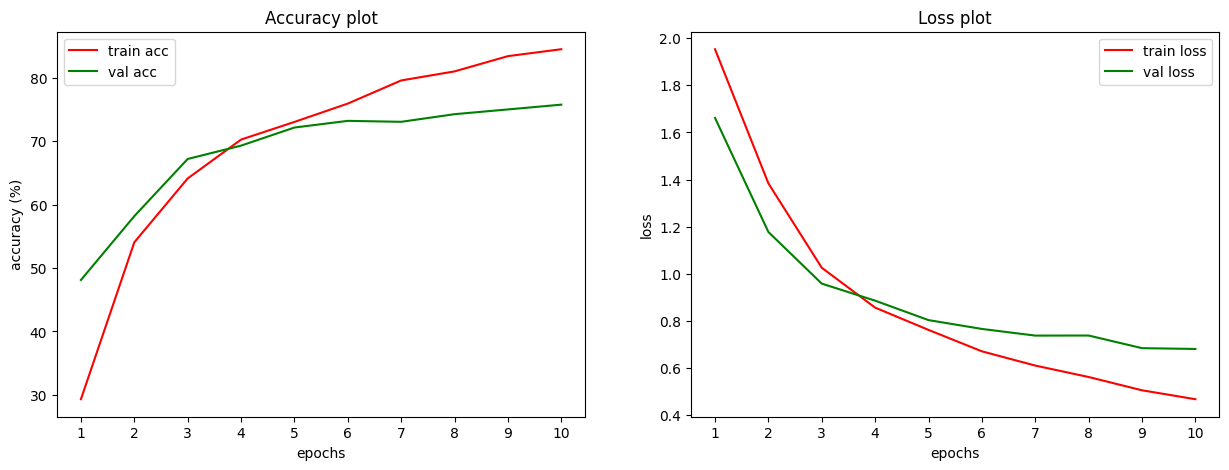

In [ ]:
print("\nEXPERIMENT 1")
m1 = ResnetTransformer(embed_dim=256, num_patches=49, num_heads=8, num_layers=2, num_classes=9)
_, t_l1, t_a1, v_l1, v_a1 = train_model(m1, train_dl_std, val_dl_std, EPOCHS, lr=1e-4, unfreeze_backbone=False)

plot_results(t_a1, v_a1, t_l1, v_l1)


Increasing dimensions and layers caused strong overfitting; the model memorizes the training set (>85%) but fails to improve on validation.

Doubling the model capacity improved validation accuracy to ~76%, but the widening gap between the training and validation curves indicates a higher risk of overfitting compared to the baseline.

EXPERIMENT 2

Increases the depth to 4 layers while keeping the embedding dimension small (128).
It checks if the model requires more sequential processing steps.


EXPERIMENT 2
Using device: cuda
Epoch [1/10] Train loss: 2.0304 | Train accuracy: 0.2585 | Val loss: 1.8251 | Val accuracy: 0.3203
Epoch [2/10] Train loss: 1.5762 | Train accuracy: 0.4744 | Val loss: 1.3767 | Val accuracy: 0.5564
Epoch [3/10] Train loss: 1.2209 | Train accuracy: 0.6005 | Val loss: 1.1200 | Val accuracy: 0.6376
Epoch [4/10] Train loss: 1.0307 | Train accuracy: 0.6614 | Val loss: 0.9885 | Val accuracy: 0.6767
Epoch [5/10] Train loss: 0.8919 | Train accuracy: 0.7054 | Val loss: 0.8902 | Val accuracy: 0.7083
Epoch [6/10] Train loss: 0.8158 | Train accuracy: 0.7318 | Val loss: 0.8588 | Val accuracy: 0.7113
Epoch [7/10] Train loss: 0.7502 | Train accuracy: 0.7524 | Val loss: 0.7837 | Val accuracy: 0.7353
Epoch [8/10] Train loss: 0.6761 | Train accuracy: 0.7837 | Val loss: 0.7597 | Val accuracy: 0.7308
Epoch [9/10] Train loss: 0.6454 | Train accuracy: 0.7946 | Val loss: 0.7415 | Val accuracy: 0.7368
Epoch [10/10] Train loss: 0.6174 | Train accuracy: 0.7987 | Val loss: 0.7094

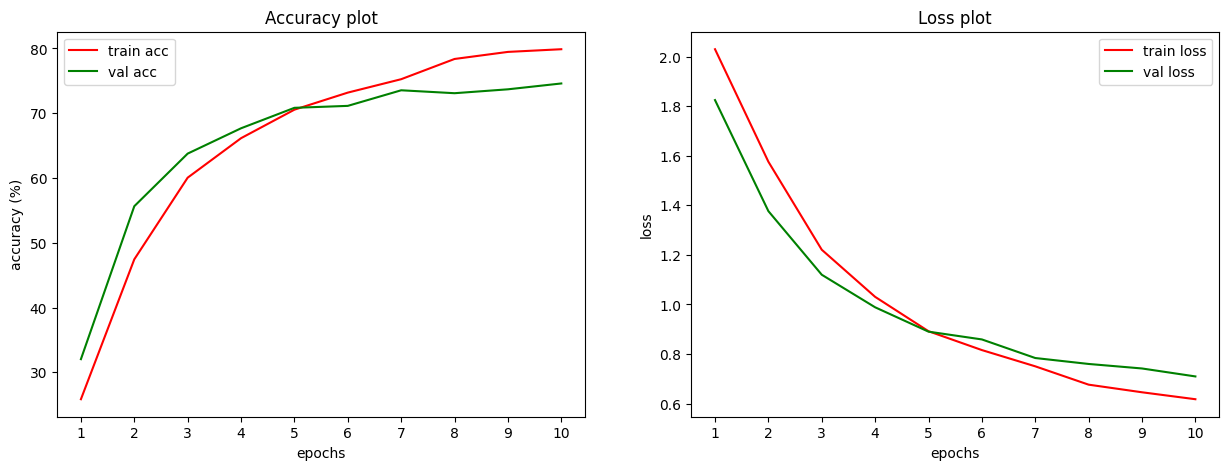

In [ ]:
print("\nEXPERIMENT 2")
m2 = ResnetTransformer(embed_dim=128, num_patches=49, num_heads=4, num_layers=4, num_classes=9)
_, t_l2, t_a2, v_l2, v_a2 = train_model(m2, train_dl_std, val_dl_std, EPOCHS, lr=1e-4, unfreeze_backbone=False)

plot_results(t_a2, v_a2, t_l2, v_l2)

Increasing depth did not aid generalization, maintaining a noticeable gap between the training and validation curves.

EXPERIMENT 3

Expands the width (256 dim, 8 heads) but keeps the model shallow (1 layer). It investigates if learning richer, high-dimensional feature representations is more important than deep reasoning for this specific task.


EXPERIMENT 3
Using device: cuda
Epoch [1/10] Train loss: 2.0892 | Train accuracy: 0.2178 | Val loss: 1.9357 | Val accuracy: 0.3805
Epoch [2/10] Train loss: 1.6995 | Train accuracy: 0.4289 | Val loss: 1.4757 | Val accuracy: 0.5098
Epoch [3/10] Train loss: 1.2785 | Train accuracy: 0.5726 | Val loss: 1.1521 | Val accuracy: 0.6135
Epoch [4/10] Train loss: 1.0309 | Train accuracy: 0.6471 | Val loss: 1.0034 | Val accuracy: 0.6586
Epoch [5/10] Train loss: 0.8894 | Train accuracy: 0.6926 | Val loss: 0.9337 | Val accuracy: 0.6707
Epoch [6/10] Train loss: 0.7953 | Train accuracy: 0.7257 | Val loss: 0.8831 | Val accuracy: 0.6782
Epoch [7/10] Train loss: 0.7243 | Train accuracy: 0.7547 | Val loss: 0.8532 | Val accuracy: 0.6812
Epoch [8/10] Train loss: 0.6950 | Train accuracy: 0.7622 | Val loss: 0.8359 | Val accuracy: 0.6992
Epoch [9/10] Train loss: 0.6347 | Train accuracy: 0.7919 | Val loss: 0.8214 | Val accuracy: 0.7083
Epoch [10/10] Train loss: 0.6040 | Train accuracy: 0.7972 | Val loss: 0.8578

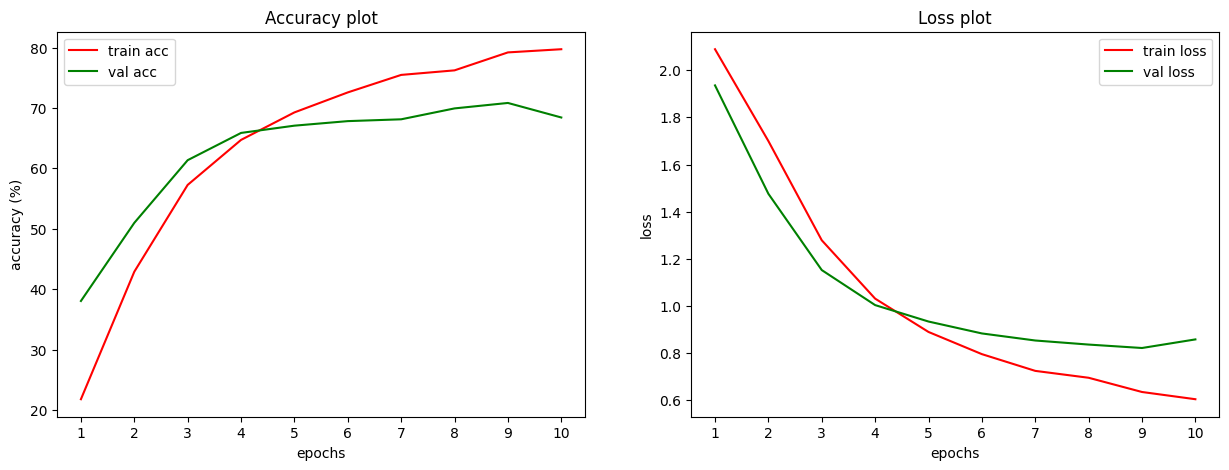

In [ ]:
print("\nEXPERIMENT 3")
m3 = ResnetTransformer(embed_dim=256, num_patches=49, num_heads=8, num_layers=1, num_classes=9)
_, t_l3, t_a3, v_l3, v_a3 = train_model(m3, train_dl_std, val_dl_std, EPOCHS, lr=1e-4, unfreeze_backbone=False)

plot_results(t_a3, v_a3, t_l3, v_l3)

A wider embedding increased training power, but confirmed that excessive complexity leads to performance saturation on the validation set.

EXPERIMENT 4

Doubles the attention heads to 8 while maintaining the baseline dimensions and depth.
It tests if the model performs better by attending to more distinct parts of the image simultaneously without increasing the overall model size.



EXPERIMENT 4
Using device: cuda
Epoch [1/10] Train loss: 2.1082 | Train accuracy: 0.2047 | Val loss: 2.0512 | Val accuracy: 0.2075
Epoch [2/10] Train loss: 1.9271 | Train accuracy: 0.3179 | Val loss: 1.8184 | Val accuracy: 0.3699
Epoch [3/10] Train loss: 1.6459 | Train accuracy: 0.4650 | Val loss: 1.4914 | Val accuracy: 0.4782
Epoch [4/10] Train loss: 1.3554 | Train accuracy: 0.5568 | Val loss: 1.2593 | Val accuracy: 0.5504
Epoch [5/10] Train loss: 1.1606 | Train accuracy: 0.6204 | Val loss: 1.1184 | Val accuracy: 0.5985
Epoch [6/10] Train loss: 1.0512 | Train accuracy: 0.6486 | Val loss: 1.0233 | Val accuracy: 0.6256
Epoch [7/10] Train loss: 0.9663 | Train accuracy: 0.6738 | Val loss: 0.9676 | Val accuracy: 0.6511
Epoch [8/10] Train loss: 0.8954 | Train accuracy: 0.7047 | Val loss: 0.9133 | Val accuracy: 0.6917
Epoch [9/10] Train loss: 0.8638 | Train accuracy: 0.7148 | Val loss: 0.8743 | Val accuracy: 0.6917
Epoch [10/10] Train loss: 0.8092 | Train accuracy: 0.7344 | Val loss: 0.8444

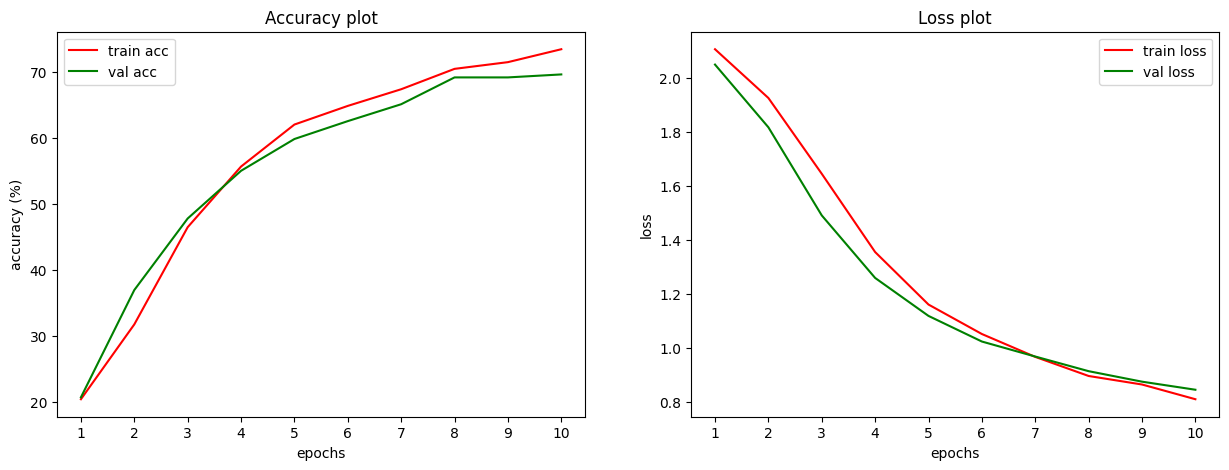

In [ ]:
print("\nEXPERIMENT 4")
m4 = ResnetTransformer(embed_dim=128, num_patches=49, num_heads=8, num_layers=1, num_classes=9)
_, t_l4, t_a4, v_l4, v_a4 = train_model(m4, train_dl_std, val_dl_std, EPOCHS, lr=1e-4, unfreeze_backbone=False)

plot_results(t_a4, v_a4, t_l4, v_l4)

Doubling the attention heads had a negligible impact. Accuracy is low again.

EXPERIMENT 5

Introduces aggressive data augmentation (rotation, flips, color jitter) while keeping the baseline model architecture.
It aims to force the model to learn invariant features and reduce overfitting by artificially increasing data variety.


EXPERIMENT 5
FULL DATASET: Using all 3323 images
Using device: cuda
Epoch [1/10] Train loss: 2.1406 | Train accuracy: 0.1802 | Val loss: 2.0778 | Val accuracy: 0.1684
Epoch [2/10] Train loss: 1.9904 | Train accuracy: 0.2487 | Val loss: 1.8512 | Val accuracy: 0.3368
Epoch [3/10] Train loss: 1.7478 | Train accuracy: 0.4108 | Val loss: 1.5320 | Val accuracy: 0.4541
Epoch [4/10] Train loss: 1.4666 | Train accuracy: 0.5102 | Val loss: 1.2739 | Val accuracy: 0.5579
Epoch [5/10] Train loss: 1.2722 | Train accuracy: 0.5730 | Val loss: 1.1209 | Val accuracy: 0.5940
Epoch [6/10] Train loss: 1.1639 | Train accuracy: 0.5937 | Val loss: 1.0267 | Val accuracy: 0.6346
Epoch [7/10] Train loss: 1.0800 | Train accuracy: 0.6321 | Val loss: 0.9746 | Val accuracy: 0.6466
Epoch [8/10] Train loss: 1.0133 | Train accuracy: 0.6622 | Val loss: 0.9037 | Val accuracy: 0.6857
Epoch [9/10] Train loss: 0.9823 | Train accuracy: 0.6663 | Val loss: 0.8781 | Val accuracy: 0.6872
Epoch [10/10] Train loss: 0.9321 | Train

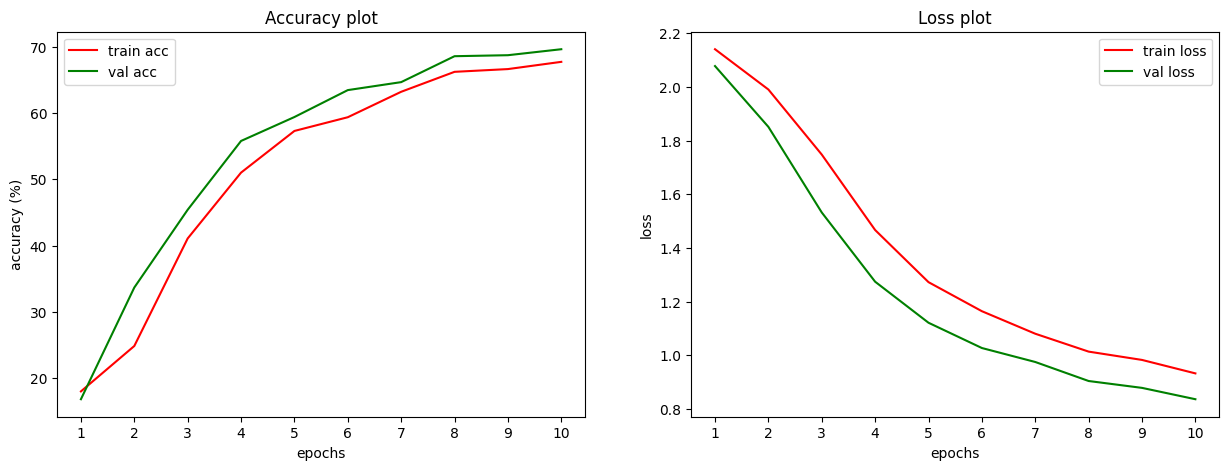

In [ ]:
print("\nEXPERIMENT 5")

# more aggressive transformtions for the training
aug_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# augmented dataset
trainset_aug = datasets.ImageFolder(root=train_path, transform=aug_transform)
train_dl_aug, val_dl_aug = prepare_dataloaders(trainset_aug, batch_size=BATCH_SIZE, subset_ratio=FAST_RATIO)

m5 = ResnetTransformer(embed_dim=128, num_patches=49, num_heads=4, num_layers=1, num_classes=9)
_, t_l5, t_a5, v_l5, v_a5 = train_model(m5, train_dl_aug, val_dl_std, EPOCHS, lr=1e-4, unfreeze_backbone=False)

plot_results(t_a5, v_a5, t_l5, v_l5)

Introducing Data Augmentation completely eliminated overfitting (overlapping curves), though accuracy remains limited by the frozen backbone.

EXPERIMENT 6

Unfreezes the ResNet backbone weights while using data augmentation.
It allows the pre-trained CNN to adjust its feature extraction filters specifically for your dataset, likely improving accuracy.


EXPERIMENT 6
Using device: cuda
Unfreezing ResNet backbone
Epoch [1/10] Train loss: 2.2197 | Train accuracy: 0.1193 | Val loss: 2.1790 | Val accuracy: 0.1714
Epoch [2/10] Train loss: 2.1088 | Train accuracy: 0.2246 | Val loss: 2.0660 | Val accuracy: 0.2481
Epoch [3/10] Train loss: 1.9997 | Train accuracy: 0.2825 | Val loss: 1.9376 | Val accuracy: 0.2602
Epoch [4/10] Train loss: 1.8750 | Train accuracy: 0.3348 | Val loss: 1.8011 | Val accuracy: 0.3654
Epoch [5/10] Train loss: 1.7395 | Train accuracy: 0.4304 | Val loss: 1.6500 | Val accuracy: 0.4722
Epoch [6/10] Train loss: 1.5961 | Train accuracy: 0.5380 | Val loss: 1.4955 | Val accuracy: 0.5549
Epoch [7/10] Train loss: 1.4598 | Train accuracy: 0.6091 | Val loss: 1.3649 | Val accuracy: 0.6075
Epoch [8/10] Train loss: 1.3395 | Train accuracy: 0.6527 | Val loss: 1.2517 | Val accuracy: 0.6436
Epoch [9/10] Train loss: 1.2410 | Train accuracy: 0.6798 | Val loss: 1.1558 | Val accuracy: 0.6977
Epoch [10/10] Train loss: 1.1515 | Train accuracy

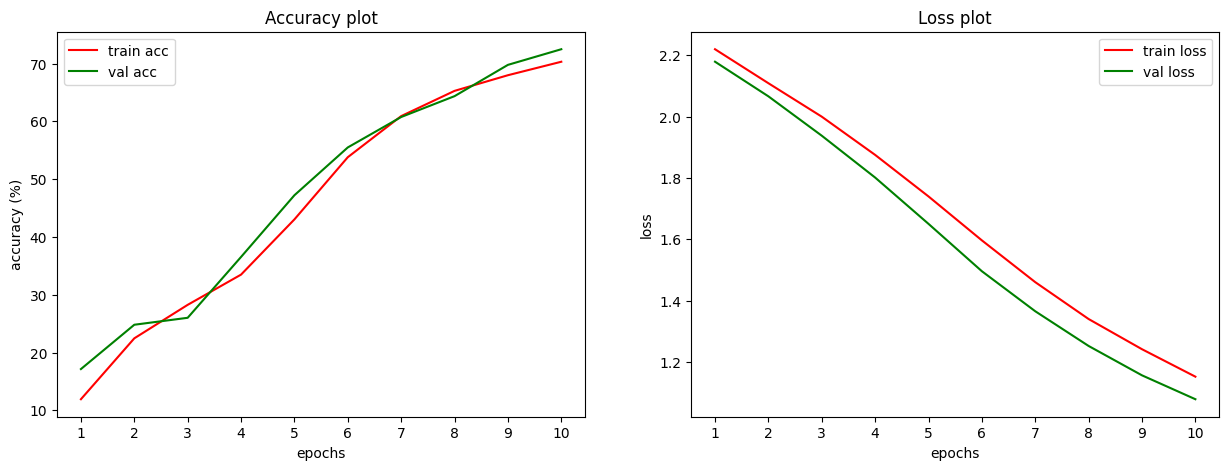

In [ ]:
print("\nEXPERIMENT 6")

m6 = ResnetTransformer(embed_dim=128, num_patches=49, num_heads=4, num_layers=1, num_classes=9)
m6, t_l6, t_a6, v_l6, v_a6 = train_model(m6, train_dl_aug, val_dl_std, EPOCHS, lr=1e-4, unfreeze_backbone=True)

plot_results(t_a6, v_a6, t_l6, v_l6)

The best configuration: unfreezing the ResNet combined with Augmentation allowed the model to learn specific features, boosting accuracy without overfitting.

FINAL TEST 1

Extends training to 20 epochs and lowers the learning rate to 5e-5 on the unfrozen model.
It gives the model more time to converge and fine-tune the weights.


FINAL TEST 1
FULL DATASET: Using all 3323 images
Using device: cuda
Unfreezing ResNet backbone
Epoch [1/20] Train loss: 2.0141 | Train accuracy: 0.2664 | Val loss: 1.7325 | Val accuracy: 0.4165
Epoch [2/20] Train loss: 1.4562 | Train accuracy: 0.5628 | Val loss: 1.2401 | Val accuracy: 0.6105
Epoch [3/20] Train loss: 1.0186 | Train accuracy: 0.7167 | Val loss: 0.9052 | Val accuracy: 0.7398
Epoch [4/20] Train loss: 0.7301 | Train accuracy: 0.8160 | Val loss: 0.7459 | Val accuracy: 0.7744
Epoch [5/20] Train loss: 0.5484 | Train accuracy: 0.8631 | Val loss: 0.6320 | Val accuracy: 0.7970
Epoch [6/20] Train loss: 0.4090 | Train accuracy: 0.9074 | Val loss: 0.5762 | Val accuracy: 0.8105
Epoch [7/20] Train loss: 0.3210 | Train accuracy: 0.9375 | Val loss: 0.5193 | Val accuracy: 0.8436
Epoch [8/20] Train loss: 0.2545 | Train accuracy: 0.9511 | Val loss: 0.5194 | Val accuracy: 0.8301
Epoch [9/20] Train loss: 0.2028 | Train accuracy: 0.9691 | Val loss: 0.4949 | Val accuracy: 0.8376
Epoch [10/20]

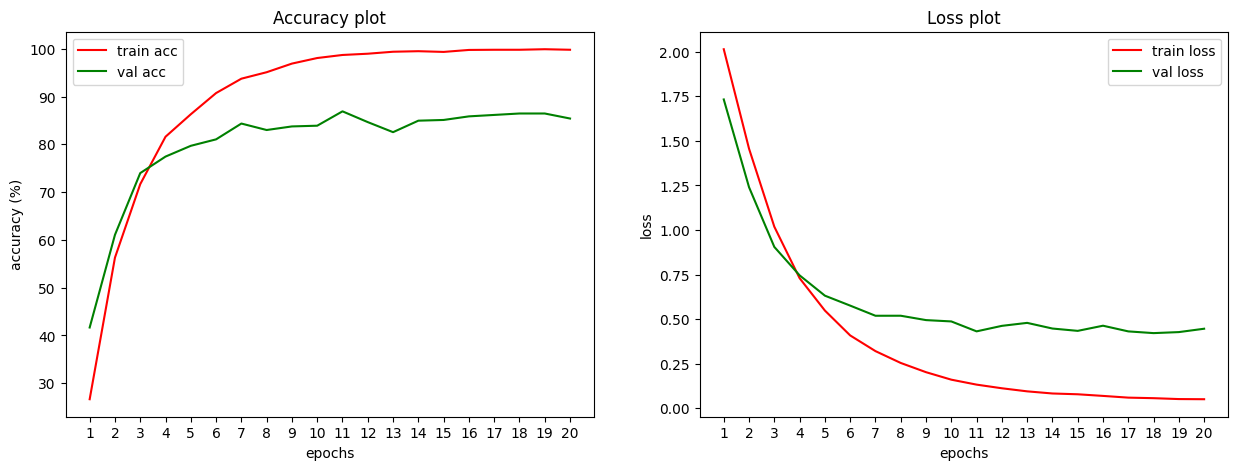

In [ ]:
print("\nFINAL TEST 1")

# augmented dataset
aug_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
trainset_aug = datasets.ImageFolder(root=train_path, transform=aug_transform)
train_dl_aug, val_dl_std = prepare_dataloaders(trainset_aug, batch_size=128, subset_ratio=1.0)

model_opt_1 = ResnetTransformer(
    embed_dim=128,
    num_patches=49,
    num_heads=4,
    num_layers=1,
    num_classes=9
)

model_opt_1, t_l_1, t_a_1, v_l_1, v_a_1 = train_model(
    model_opt_1,
    train_dl_aug,
    val_dl_std,
    num_epochs=20,
    lr=5e-5,
    unfreeze_backbone=True
)

plot_results(t_a_1, v_a_1, t_l_1, v_l_1)

The model reaches excellent accuracy (~86%), but the aggressive Learning Rate leads to noticeable overfitting in the final epochs.

FINAL TEST 2

Further reduces the learning rate to 1e-5 over 20 epochs.
It is a stabilization strategy designed to figh overfitting.


FINAL TEST 2
Using device: cuda
Unfreezing ResNet backbone
Epoch [1/20] Train loss: 2.1535 | Train accuracy: 0.1956 | Val loss: 2.1111 | Val accuracy: 0.2045
Epoch [2/20] Train loss: 2.0659 | Train accuracy: 0.2442 | Val loss: 2.0348 | Val accuracy: 0.2421
Epoch [3/20] Train loss: 1.9612 | Train accuracy: 0.2784 | Val loss: 1.9249 | Val accuracy: 0.2632
Epoch [4/20] Train loss: 1.8352 | Train accuracy: 0.3153 | Val loss: 1.8065 | Val accuracy: 0.3338
Epoch [5/20] Train loss: 1.6917 | Train accuracy: 0.4187 | Val loss: 1.6587 | Val accuracy: 0.4391
Epoch [6/20] Train loss: 1.5377 | Train accuracy: 0.5211 | Val loss: 1.5167 | Val accuracy: 0.5053
Epoch [7/20] Train loss: 1.4168 | Train accuracy: 0.5681 | Val loss: 1.4223 | Val accuracy: 0.5459
Epoch [8/20] Train loss: 1.3090 | Train accuracy: 0.6106 | Val loss: 1.3299 | Val accuracy: 0.5820
Epoch [9/20] Train loss: 1.2131 | Train accuracy: 0.6467 | Val loss: 1.2576 | Val accuracy: 0.6105
Epoch [10/20] Train loss: 1.1388 | Train accuracy

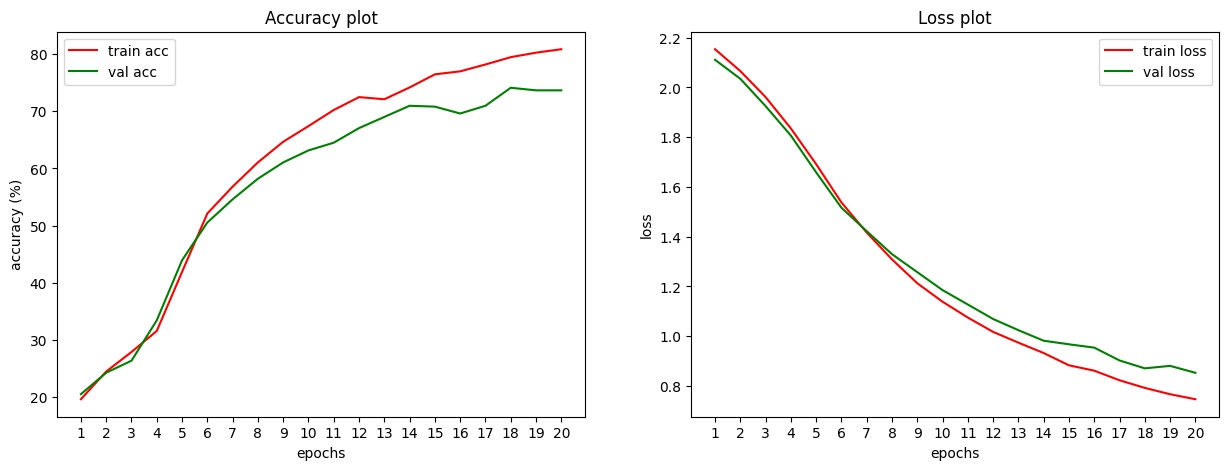

In [ ]:
print("\nFINAL TEST 2")

model_opt_2 = ResnetTransformer(
    embed_dim=128,
    num_patches=49,
    num_heads=4,
    num_layers=1,
    num_classes=9
)

LOWER_LR = 1e-5
LONGER_EPOCHS = 20

model_opt_2, t_l_2, t_a_2, v_l_2, v_a_2 = train_model(
    model_opt_2,
    train_dl_aug,
    val_dl_std,
    num_epochs=LONGER_EPOCHS,
    lr=LOWER_LR,
    unfreeze_backbone=True
)

plot_results(t_a_2, v_a_2, t_l_2, v_l_2)

The model exhibits exceptional stability with almost overlapping curves, but the learning pace is too slow.

FINAL TEST 3

Combines the wider architecture (256 dim, 8 heads) with backbone fine-tuning and a moderate learning rate (3e-5).
It tests if a high-capacity model can outperform the smaller baseline when properly fine-tuned with adequate time and data augmentation.


FINAL TEST 3
FULL DATASET: Using all 3323 images
Using device: cuda
Unfreezing ResNet backbone
Epoch [1/20] Train loss: 2.0983 | Train accuracy: 0.2050 | Val loss: 1.9257 | Val accuracy: 0.2602
Epoch [2/20] Train loss: 1.7119 | Train accuracy: 0.4078 | Val loss: 1.4614 | Val accuracy: 0.5278
Epoch [3/20] Train loss: 1.2271 | Train accuracy: 0.6569 | Val loss: 1.0261 | Val accuracy: 0.6782
Epoch [4/20] Train loss: 0.8687 | Train accuracy: 0.7479 | Val loss: 0.8230 | Val accuracy: 0.7218
Epoch [5/20] Train loss: 0.6512 | Train accuracy: 0.8164 | Val loss: 0.6920 | Val accuracy: 0.7699
Epoch [6/20] Train loss: 0.5136 | Train accuracy: 0.8589 | Val loss: 0.6076 | Val accuracy: 0.8015
Epoch [7/20] Train loss: 0.4064 | Train accuracy: 0.8834 | Val loss: 0.5488 | Val accuracy: 0.8135
Epoch [8/20] Train loss: 0.3348 | Train accuracy: 0.9120 | Val loss: 0.5422 | Val accuracy: 0.8211
Epoch [9/20] Train loss: 0.2805 | Train accuracy: 0.9278 | Val loss: 0.4992 | Val accuracy: 0.8346
Epoch [10/20]

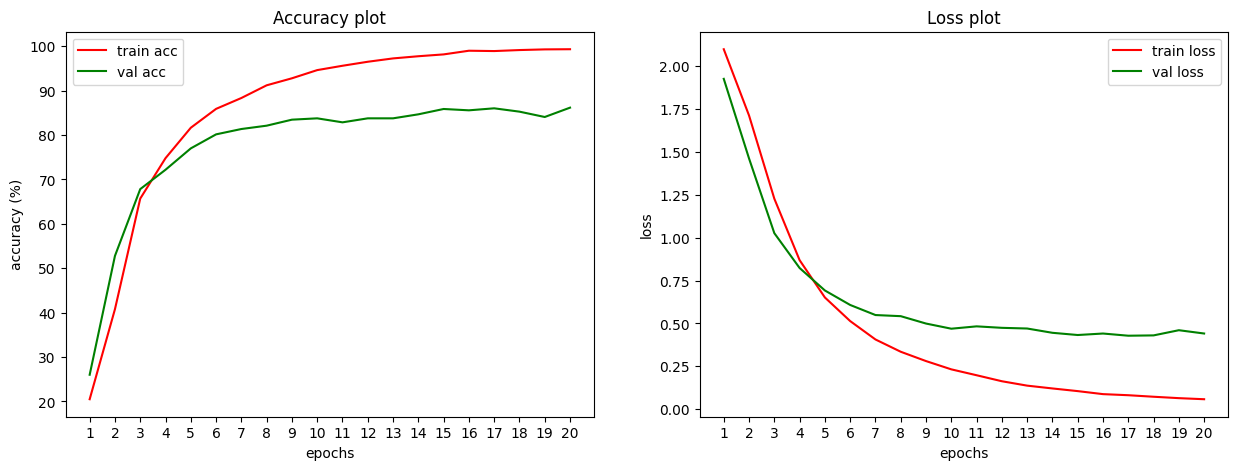

In [ ]:
print("\nFINAL TEST 3")

# augmentation dataset
aug_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
trainset_aug = datasets.ImageFolder(root=train_path, transform=aug_transform)
train_dl_aug, val_dl_std = prepare_dataloaders(trainset_aug, batch_size=128, subset_ratio=1.0)

model_opt_3 = ResnetTransformer(
    embed_dim=256,
    num_patches=49,
    num_heads=8,
    num_layers=1,
    num_classes=9
)

model_opt_3, t_l_3, t_a_3, v_l_3, v_a_3 = train_model(
    model_opt_3,
    train_dl_aug,
    val_dl_std,
    num_epochs=20,
    lr=3e-5,
    unfreeze_backbone=True
)

plot_results(t_a_3, v_a_3, t_l_3, v_l_3)

This represents the optimal configuration (~87%), it is an evolution of the Final Test 1.

For the final submission, I decided to select the configuration from Final Test 3. Although this model exhibits a larger gap between training and validation curves (indicating some overfitting) compared to the more conservative experiments, it achieves the highest absolute validation accuracy (~87%).
My decision is based on the reasoning that a perfectly stable model with no overfitting but low accuracy (e.g., ~74%) is effectively underfitting and would perform poorly on the unseen test set. In this classification task, I prioritized maximizing the model's predictive power.

PART 3 - MODEL DEPLOYMENT

Now I train the model using all the dataset.

In [ ]:
print("FINAL DEPLOYMENT TRAINING")

aug_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_trainset = datasets.ImageFolder(root=train_path, transform=aug_transform)
full_loader = DataLoader(full_trainset, batch_size=128, shuffle=True, num_workers=0)

model_deploy = ResnetTransformer(
    embed_dim=256,
    num_patches=49,
    num_heads=8,
    num_layers=1,
    num_classes=9
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_deploy.to(device)

EPOCHS_FINAL = 20
LR = 3e-5

for param in model_deploy.backbone.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_deploy.parameters()), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

for epoch in range(EPOCHS_FINAL):
    model_deploy.train()
    running_loss = 0.0
    correct = 0
    total = 0

    print(f"Epoch [{epoch+1}/{EPOCHS_FINAL}] ", end="")

    for i, (images, labels) in enumerate(full_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_deploy(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        percent = (i + 1) / len(full_loader) * 100
        print(f"\rEpoch [{epoch+1}/{EPOCHS_FINAL}] Progress: {percent:.0f}% ", end="", flush=True)

    scheduler.step()
    epoch_acc = correct / total

    print(f"\rEpoch [{epoch+1}/{EPOCHS_FINAL}] Train Acc: {epoch_acc:.4f}")

FINAL DEPLOYMENT TRAINING
Epoch [1/20] Train Acc: 0.2113
Epoch [2/20] Train Acc: 0.5345
Epoch [3/20] Train Acc: 0.7243
Epoch [4/20] Train Acc: 0.7954
Epoch [5/20] Train Acc: 0.8480
Epoch [6/20] Train Acc: 0.8811
Epoch [7/20] Train Acc: 0.9163
Epoch [8/20] Train Acc: 0.9350
Epoch [9/20] Train Acc: 0.9440
Epoch [10/20] Train Acc: 0.9579
Epoch [11/20] Train Acc: 0.9627
Epoch [12/20] Train Acc: 0.9771
Epoch [13/20] Train Acc: 0.9828
Epoch [14/20] Train Acc: 0.9837
Epoch [15/20] Train Acc: 0.9886
Epoch [16/20] Train Acc: 0.9892
Epoch [17/20] Train Acc: 0.9916
Epoch [18/20] Train Acc: 0.9952
Epoch [19/20] Train Acc: 0.9958
Epoch [20/20] Train Acc: 0.9940


In [ ]:
# code snipped to upload it to huggingface
api = HfApi()

repo_id = "daniele-gotti/Waste_Classifier"
TOKEN = "..."

# create repository on huggingface
api.create_repo(
    repo_id=repo_id,
    repo_type="model",
    token=TOKEN,
    private=False,
    exist_ok=True
)

print("Repo created on huggingface")

Repo created on huggingface


In [ ]:
filepath = "./my_model_weights.pth"
torch.save(model_deploy.state_dict(), filepath)
print("Weights saved to: ", filepath)

Weights saved to:  ./my_model_weights.pth


In [ ]:
# code snippet to upload the trained model
api.upload_file(
    path_or_fileobj=filepath,
    path_in_repo="resnet_transformer.pth",
    repo_id=repo_id,
    token=TOKEN,
    commit_message="update best model"
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ./my_model_weights.pth      :   1%|1         |  567kB / 48.5MB            

CommitInfo(commit_url='https://huggingface.co/daniele-gotti/Waste_Classifier/commit/0d0915373dd4fe6ee0cbd813de04d53aee7591f8', commit_message='update best model', commit_description='', oid='0d0915373dd4fe6ee0cbd813de04d53aee7591f8', pr_url=None, repo_url=RepoUrl('https://huggingface.co/daniele-gotti/Waste_Classifier', endpoint='https://huggingface.co', repo_type='model', repo_id='daniele-gotti/Waste_Classifier'), pr_revision=None, pr_num=None)